# Análisis Exploratorio de Imágenes (EDA)

En esta sección se lleva a cabo un análisis exploratorio de las imágenes proporcionadas por el dataset full_df.csv de ODIR-5K, cuyo objetivo principal es la detección automática de patologías oculares mediante aprendizaje profundo. El conjunto de datos incluye imágenes de fondo de ojo (retinografías) correspondientes a ambos ojos (izquierdo y derecho) de cada paciente, junto con sus respectivas etiquetas diagnósticas ("labels"):

    - Normal (N)
    - Retinopatía diabética (D)
    - Glaucoma (G)
    - Cataract (C)
    - Age related Macular Degeneration (A)
    - Hypertension (H)
    - Pathological Myopia (M)
    - Other diseases/abnormalities (O)

El propósito de este análisis es examinar la estructura, calidad y disponibilidad de las imágenes, así como identificar posibles inconsistencias, variaciones en el tamaño o el formato, diferencias de contraste o brillo, y cualquier otra característica relevante que pueda impactar en la fase de preprocesamiento y entrenamiento del modelo.

In [1]:
# Importación de librerías
import pandas as pd      # Manejo de datos tabulares (DataFrames)
import numpy as np       # Operaciones numéricas y arrays
import os                # Manejo de rutas y archivos
import cv2               # Lectura y procesamiento de imágenes
import random            # Selección aleatoria
import matplotlib.pyplot as plt  # Visualización de gráficos e imágenes
import seaborn as sns    # Gráficos estadísticos mejorados
from collections import Counter  # Conteo de elementos
from tqdm import tqdm    # Barra de progreso en bucles
from scipy.stats import ttest_ind  # Prueba estadística t para comparación de medias

### Carga y vista general dataset

In [4]:
# Carga del dataset
df = pd.read_csv("../../Data/csv/full_df.csv")

# Dimendión y primeras filas del dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (6392, 19)


ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
3  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   
4  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  
3  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg  
4  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

In [5]:
# Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

### Análisis estructural de las imégens

En esta sección se analizá las dimensiones (alto, ancho y número de canales) de las imágenes del dataset, así como la orientación de las mismas, y detección de imágenes corruptas. Este análisis permite identificar la variedad de tamaños presentes, detectar posibles inconsistencias y establecer criterios adecuados para el preprocesamiento y la normalización de las imágenes antes del entrenamiento del modelo.


In [9]:
# Ruta de las imágenes
image_dir = "../../ODIR-5K/ODIR-5K/Training Images"

In [10]:
# Función para obtener las dimensiones de las imágenes y detectar archivos corruptos
def get_image_sizes(image_paths):
    """
    Analiza las rutas de los archivos de imagen para extraer sus dimensiones e identificar imágenes corruptas.

    Parámetros:
        image_paths (lista de str): Lista de rutas completas a los archivos de imagen.

    Devuelve:
        size_counts: Tamaños de imagen (H, W, C) como claves y su frecuencia como valores.
        corrupted: Lista de rutas de archivos correspondientes a imágenes que no se pudieron leer.
    """
    sizes = []
    corrupted = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            sizes.append((h, w, c))
        else:
            corrupted.append(path)

    size_counts = Counter(sizes)
    return size_counts, corrupted

Vemos los 15 tamaños de imagen más comunes y el número total de imágenes corruptas identificadas.

In [11]:
# Construir lista de rutas a todas las imágenes (izquierda y derecha)
left_paths = df['Left-Fundus'].apply(lambda x: os.path.join(image_dir, x)).tolist()
right_paths = df['Right-Fundus'].apply(lambda x: os.path.join(image_dir, x)).tolist()

# Unir ambas listas
image_paths = left_paths + right_paths

# Ejecutar para obtener tamaños de imagen y detectar imágenes corruptas
size_counts, corrupted_images = get_image_sizes(image_paths)

# Mostrar los 15 tamaños más comunes
print("Tamaños de imagen más comunes:\n")
for size, count in size_counts.most_common(15):
    print(f"{size}: {count} imágenes")

# Mostrar imágenes corruptas
print(f"\nNúmero de imágenes corruptas: {len(corrupted_images)}")

Tamaños de imagen más comunes:

(1728, 2592, 3): 3964 imágenes
(1536, 2048, 3): 978 imágenes
(1728, 2304, 3): 784 imágenes
(1934, 1956, 3): 758 imágenes
(1824, 2736, 3): 650 imágenes
(1444, 1444, 3): 508 imágenes
(2304, 3456, 3): 486 imágenes
(1984, 2976, 3): 412 imágenes
(1296, 1936, 3): 396 imágenes
(1152, 1536, 3): 384 imágenes
(2448, 3264, 3): 332 imágenes
(2056, 2124, 3): 288 imágenes
(2592, 3888, 3): 242 imágenes
(2976, 2976, 3): 236 imágenes
(2000, 2584, 3): 205 imágenes

Número de imágenes corruptas: 0


In [12]:
# Muestra una selección aleatoria de imágenes 
def show_random_images(df, image_dir, n=15):
    """
    Muestra una selección aleatoria de imágenes del dataset.

    Parámetros:
        df: DataFrame con columna 'filename'.
        image_dir: Ruta donde están las imágenes.
        n: Número de imágenes a mostrar.
    """
    all_images = df['filename'].dropna().astype(str)

    # Seleccionar aleatoriamente
    sample = all_images.sample(n=min(n, len(all_images)),random_state=42).reset_index(drop=True)
    k = len(sample)

    cols = 5
    rows = k // cols + 1  

    plt.figure(figsize=(15, 3 * rows))

    for i in range(k):
        plt.subplot(rows, cols, i + 1)
        path = os.path.join(image_dir, sample[i])
        img = cv2.imread(path)
        if img is None:  
            plt.axis('off')
            plt.title(f"{sample[i]} (no legible)")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title(sample[i])

    plt.tight_layout()
    plt.show()


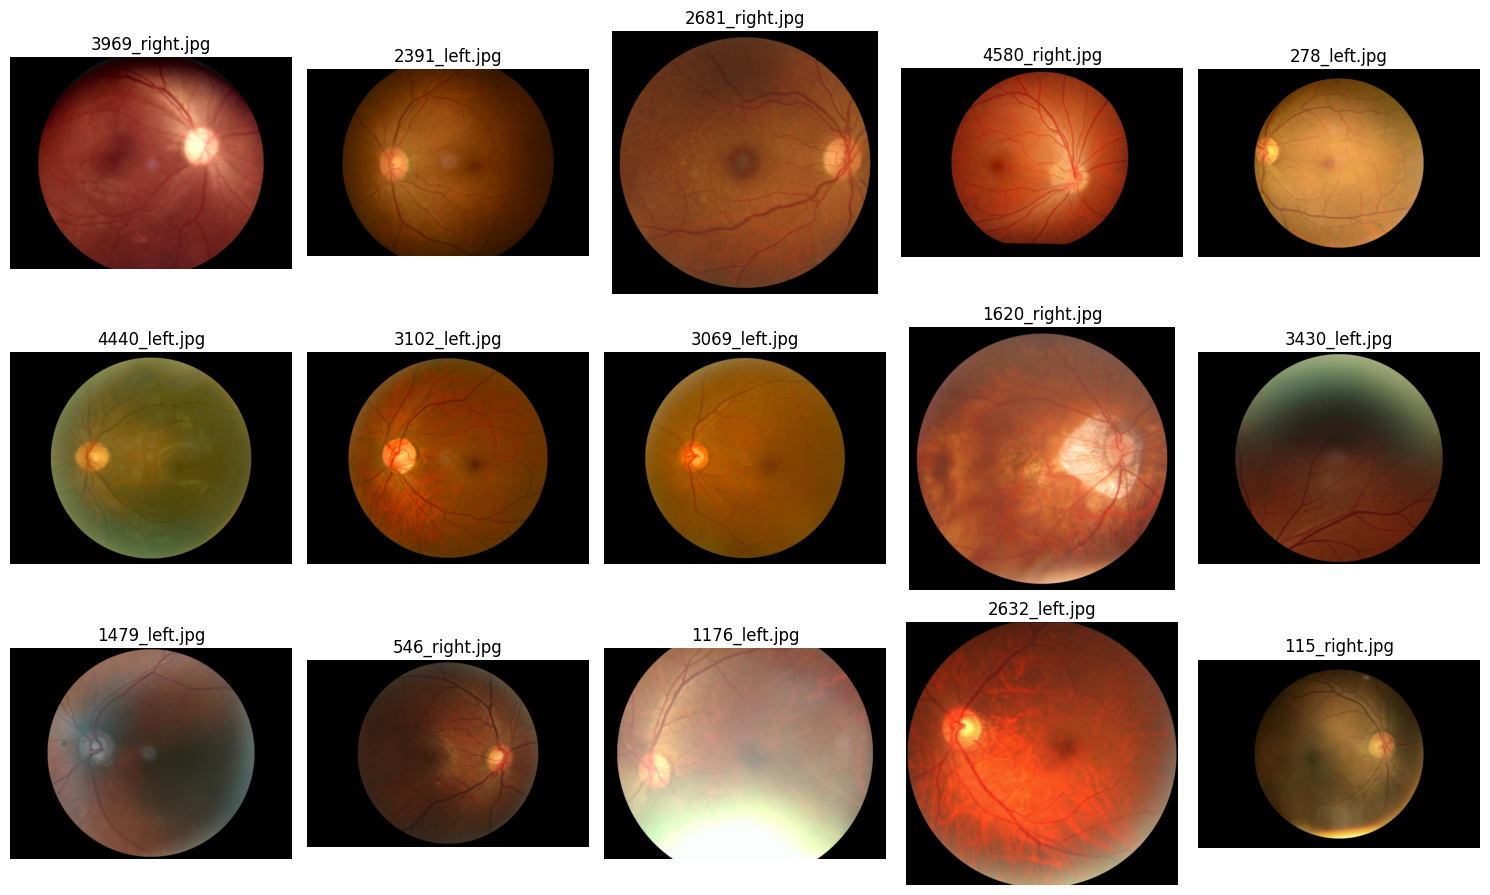

In [13]:
show_random_images(df, image_dir, n=15)

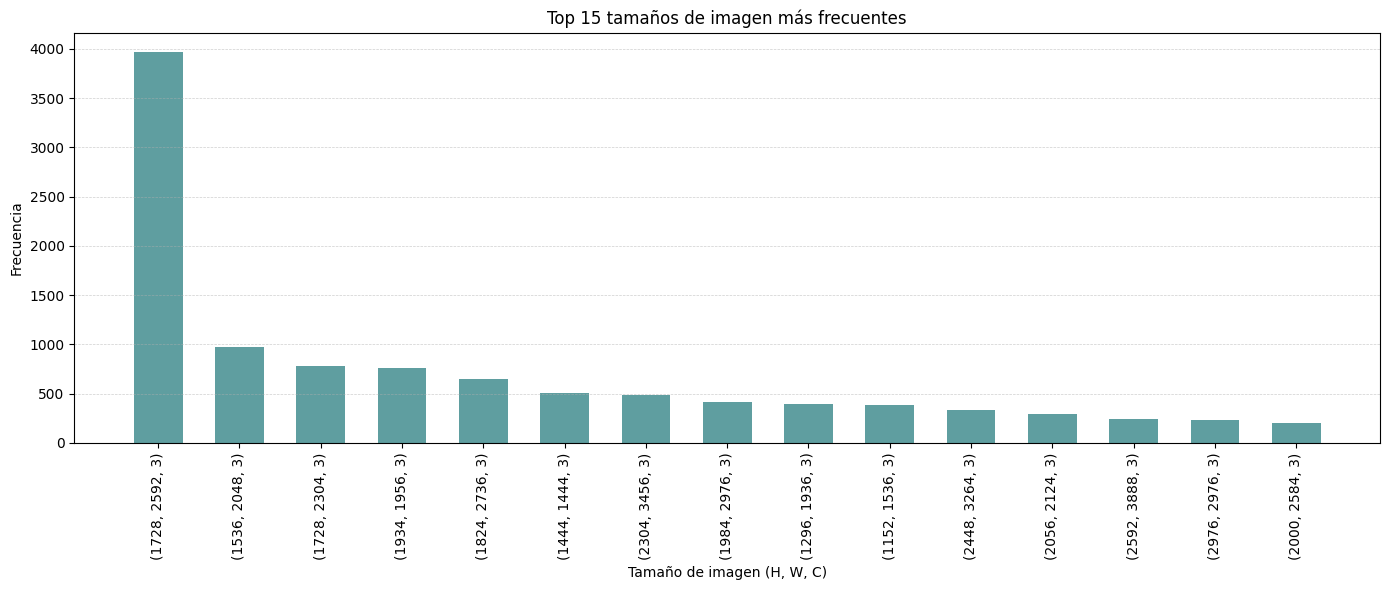

In [15]:
# Visualización de la distribución de los tamaños de imagen más comunes
# Crear dataframe df_shapes y ordenar por frecuencia descendente 
df_shapes = pd.DataFrame(size_counts.items(), columns=["tamaño", "total"])
df_shapes = df_shapes.sort_values(by='total', ascending=False)

# filtrar los tamaños más frecuentes 
top_n = 15
df_cut = df_shapes.head(top_n)

# crear figura
plt.figure(figsize=(14, 6))

# Etiquetas de tamaños (H, W, C)
x_labels = [str(shape) for shape in df_cut['tamaño']]
x = range(len(df_cut))

# Gráfico de barras
plt.bar(x, df_cut['total'], width=0.6, color='cadetblue')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xticks(x, x_labels, rotation=90)
plt.xlabel("Tamaño de imagen (H, W, C)")
plt.ylabel("Frecuencia")
plt.title(f"Top {top_n} tamaños de imagen más frecuentes")
plt.tight_layout()

plt.show()

In [16]:
# Recuento por calse dishnóstica
label_cols = ["N","D","G","C","A","H","M","O"]
conteos = df[label_cols].sum().astype(int)
total = len(df)
porc  = (conteos / total * 100).round(2)
resumen = pd.DataFrame({"casos": conteos, "%": porc})
print(resumen)

   casos      %
N   2101  32.87
D   2123  33.21
G    397   6.21
C    402   6.29
A    319   4.99
H    203   3.18
M    306   4.79
O   1588  24.84


In [17]:
# tamaño de cada lista en 'labels'
df["num_labels"] = df["labels"].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x))

# muestras con más de una etiqueta
multi_label_samples = df[df["num_labels"] > 1]

print(f"Número de filas con más de una etiqueta: {len(multi_label_samples)}")

Número de filas con más de una etiqueta: 0


### Análisis de color de las imágenes
Se procede a evaluar posibles variaciones en el brillo, contraste y distribución del color, con el objetivo de considerar su impacto en las etapas posteriores de preprocesamiento, especialmente en lo relativo a la normalización y la aplicación de técnicas de data augmentation.

In [18]:
# Histograma normalizado de niveles de gris (%)
def compute_grayscale_histogram(image_path):
    """
    Calcula el histograma promedio normalizado (en %) de niveles de gris
    a partir de una lista de rutas a imágenes.

    Parámetros:
        image_path (list of str): Lista de rutas a archivos de imagen (.jpg, .png, etc.).

    Devuelve:
        hist_total (np.ndarray): Histograma promedio de intensidad en escala de grises,
            normalizado como porcentaje (256 valores).
        num_validas (int): Número de imágenes válidas procesadas.
    """
    hist_total = np.zeros(256)
    valid_img = 0

    for path in image_path:
        img = cv2.imread(path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
        hist_total += hist
        valid_img += 1

    if hist_total.sum() > 0:
        hist_total = (hist_total / hist_total.sum()) * 100  # Convertir a porcentaje

    return hist_total, valid_img

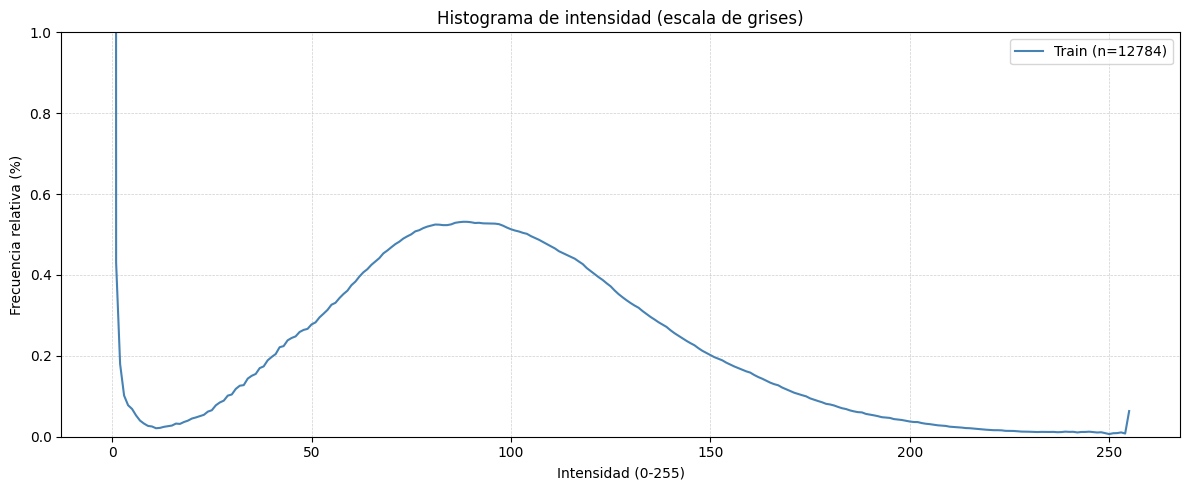

In [19]:
# Aplicamos la función al conjunto de imágenes
hist_grey, num_img = compute_grayscale_histogram(image_paths)

# Visualización del histograma promedio de niveles de gris
plt.figure(figsize=(12, 5))
plt.plot(hist_grey, label=f'Train (n={num_img})', color='steelblue')
plt.title("Histograma de intensidad (escala de grises)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


A continuación, se lleva a cabo el análisis de los canales de color Rojo, Verde y Azul (RGB) para examinar la distribución de intensidades y posibles desequilibrios cromáticos en las imágenes.

In [20]:
# Análisis promedio de histograma por canal RGB en imágenes
def compute_rgb_histogram(image_path):
    """
    Calcula el histograma promedio de los canales RGB (Rojo, Verde y Azul) 
    a partir de una lista de imágenes.

    Parámetros:
        image_path (list of str): Rutas de las imágenes en formato .jpg.

    Devuelve:
        b_hist, g_hist, r_hist (np.ndarray): Histogramas promedio de los canales Azul, Verde y Rojo.
    """

    b_hist = np.zeros(256)
    g_hist = np.zeros(256)
    r_hist = np.zeros(256)
    valid_count = 0  

    for path in tqdm(image_path):
        img = cv2.imread(path)
        if img is None:
            continue  
        valid_count += 1

        # Separar canales
        b_channel = img[:, :, 0]
        g_channel = img[:, :, 1]
        r_channel = img[:, :, 2]

        # Calcular histogramas y acumular
        b_hist += cv2.calcHist([b_channel], [0], None, [256], [0, 256]).ravel()
        g_hist += cv2.calcHist([g_channel], [0], None, [256], [0, 256]).ravel()
        r_hist += cv2.calcHist([r_channel], [0], None, [256], [0, 256]).ravel()

    # Calcular promedios
    if valid_count > 0:
        b_hist /= valid_count
        g_hist /= valid_count
        r_hist /= valid_count

    return b_hist, g_hist, r_hist


In [21]:
# Cálculo de histogramas RGB para las imágenes del dataset
image_b_hist, image_g_hist, image_r_hist = compute_rgb_histogram(image_paths)

100%|██████████| 12784/12784 [07:11<00:00, 29.60it/s]


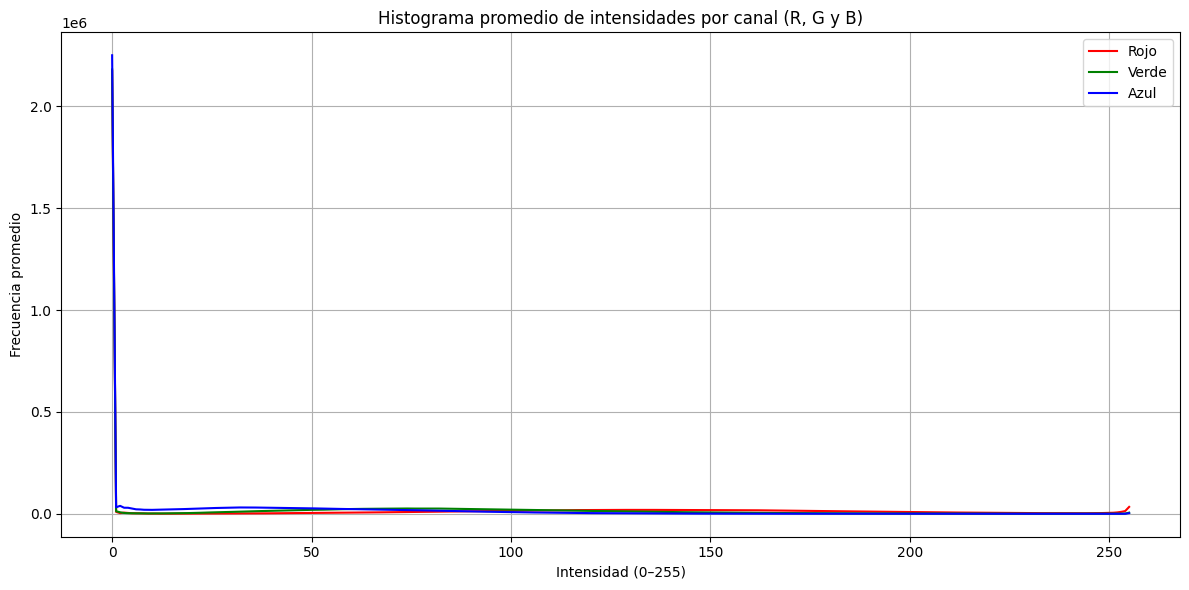

In [22]:
# visualización del histograma promedio de intensidades por canal RGB
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(image_r_hist, color='red', label='Rojo')

# Canal Verde
plt.plot(image_g_hist, color='green', label='Verde')

# Canal Azul
plt.plot(image_b_hist, color='blue', label='Azul')

plt.title("Histograma promedio de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

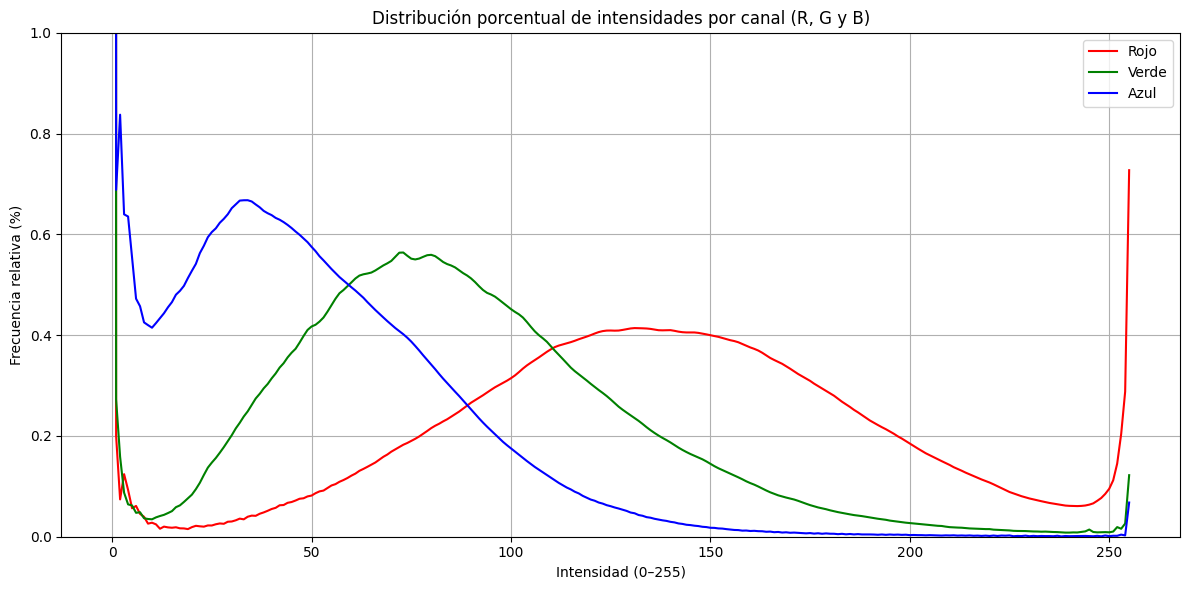

In [23]:
# Funcióm para normalizar el histograma
def normalize_histogram_percent(hist):
    return hist / hist.sum() * 100  

# Normalizamos todos los canales
r_hist_norm = normalize_histogram_percent(image_r_hist)
g_hist_norm = normalize_histogram_percent(image_g_hist)
b_hist_norm = normalize_histogram_percent(image_b_hist)

# Graficamos los histogramas normalizados
plt.figure(figsize=(12, 6))

# Canal Rojo
plt.plot(r_hist_norm, color='red', label='Rojo')

# Canal Verde
plt.plot(g_hist_norm, color='green', label='Verde')

# Canal Azul
plt.plot(b_hist_norm, color='blue', label='Azul')

plt.title("Distribución porcentual de intensidades por canal (R, G y B)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia relativa (%)")
plt.ylim(0, 1.0) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Análisis de calidad de las imágenes

A continuación, se realiza el análisis de la calidad de las imágenes, determinando su nivel de brillo y contraste, para identificar problemas (bajo contraste, iluminación desigual) que puedan introducir sesgos.

Analizando imágenes: 100%|██████████| 7000/7000 [05:49<00:00, 20.03it/s]



=== RESUMEN ===
Dark Images: 516 (7.4%)
Low Contrast Images: 204 (2.9%)
Bright Images: 143 (2.0%)
High Contrast Images: 91 (1.3%)


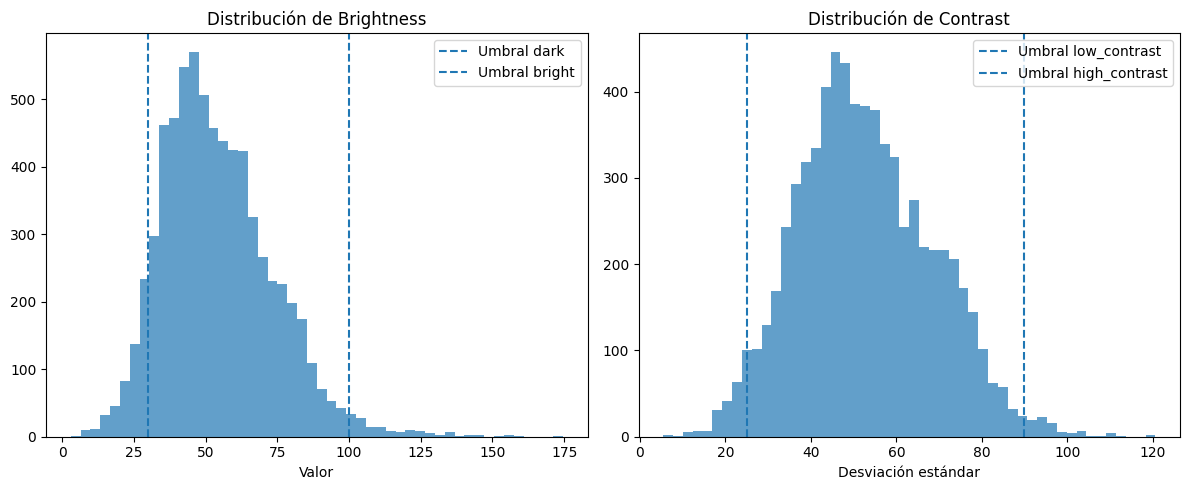

In [25]:
# Umbrales (ajustables) los valores se han ajustado tras varias pruebas
THRESHOLDS = {
    'dark': 30,
    'low_contrast': 25,
    'bright': 100,
    'high_contrast': 90
}

def analyze_image(image_path):
    """
    Analiza la calidad de una imagen calculando brillo, contraste
    y detectando si está oscura, brillante, con bajo o alto contraste.
    """
    img = cv2.imread(image_path)
    if img is None: return None
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calcular brillo y contraste
    brightness, contrast = np.mean(gray), np.std(gray)
    
    return {
        'brightness': brightness,
        'contrast': contrast,
        'is_dark': brightness < THRESHOLDS['dark'],
        'is_bright': brightness > THRESHOLDS['bright'],
        'is_low_contrast': contrast < THRESHOLDS['low_contrast'],
        'is_high_contrast': contrast > THRESHOLDS['high_contrast'],
        'hist': cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    }

def analyze_dataset(image_dir, sample_size=None):
    """
    Analiza un conjunto de imágenes y devuelve estadísticas de brillo y contraste.
    """
    paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    paths = random.sample(paths, sample_size) if sample_size else paths
    
    categories = ['dark', 'low_contrast', 'bright', 'high_contrast']
    results = {k: [] for k in categories}
    results['all'] = []
    
    for path in tqdm(paths, desc="Analizando imágenes"):
        if analysis := analyze_image(path):
            results['all'].append(analysis)
            for cat in categories:
                if analysis[f'is_{cat}']: results[cat].append(path)
    
    stats = {
        'total': len(results['all']),
        **{f'{k}_images': len(v) for k, v in results.items() if k != 'all'},
        'mean_brightness': np.mean([r['brightness'] for r in results['all']]),
        'mean_contrast': np.mean([r['contrast'] for r in results['all']]),
        **{f'{k}_paths': v for k, v in results.items() if k != 'all'}
    }
    
    return stats, results['all']

# Visualización 
def plot_stats(results):
    """
    Muestra histogramas de la distribución de brillo y contraste en las imágenes analizadas.
    """
    metrics = ['brightness', 'contrast']
    thresholds = {
        'brightness': ('dark', 'bright'), 
        'contrast': ('low_contrast', 'high_contrast')
    }
    
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 2, i)
        plt.hist([r[metric] for r in results], bins=50, alpha=0.7)
        for t in thresholds[metric]:
            plt.axvline(x=THRESHOLDS[t], linestyle='--', label=f'Umbral {t}')
        plt.title(f'Distribución de {metric.capitalize()}')
        plt.xlabel('Valor' if metric == 'brightness' else 'Desviación estándar')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Uso
stats, results = analyze_dataset("../../ODIR-5K/ODIR-5K/Training Images")
print("\n=== RESUMEN ===")
[print(f"{k.replace('_', ' ').title()}: {v} ({v/stats['total']:.1%})") 
for k, v in stats.items() if k.endswith('images')]

plot_stats(results)

Se lleva a cabo un análisis automático de calidad de imagen, evaluando métricas de brillo y contraste en todas las fotografías del conjunto.
Mediante umbrales predefinidos, las imágenes se clasifican en categorías como oscuras, brillantes, bajo contraste o alto contraste.



/var/folders/7z/6sq72d5x0s948s3fwhhpbthh0000gn/T/ipykernel_2146/2846364917.py:43: UserWarning: Glyph 27 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/retina/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


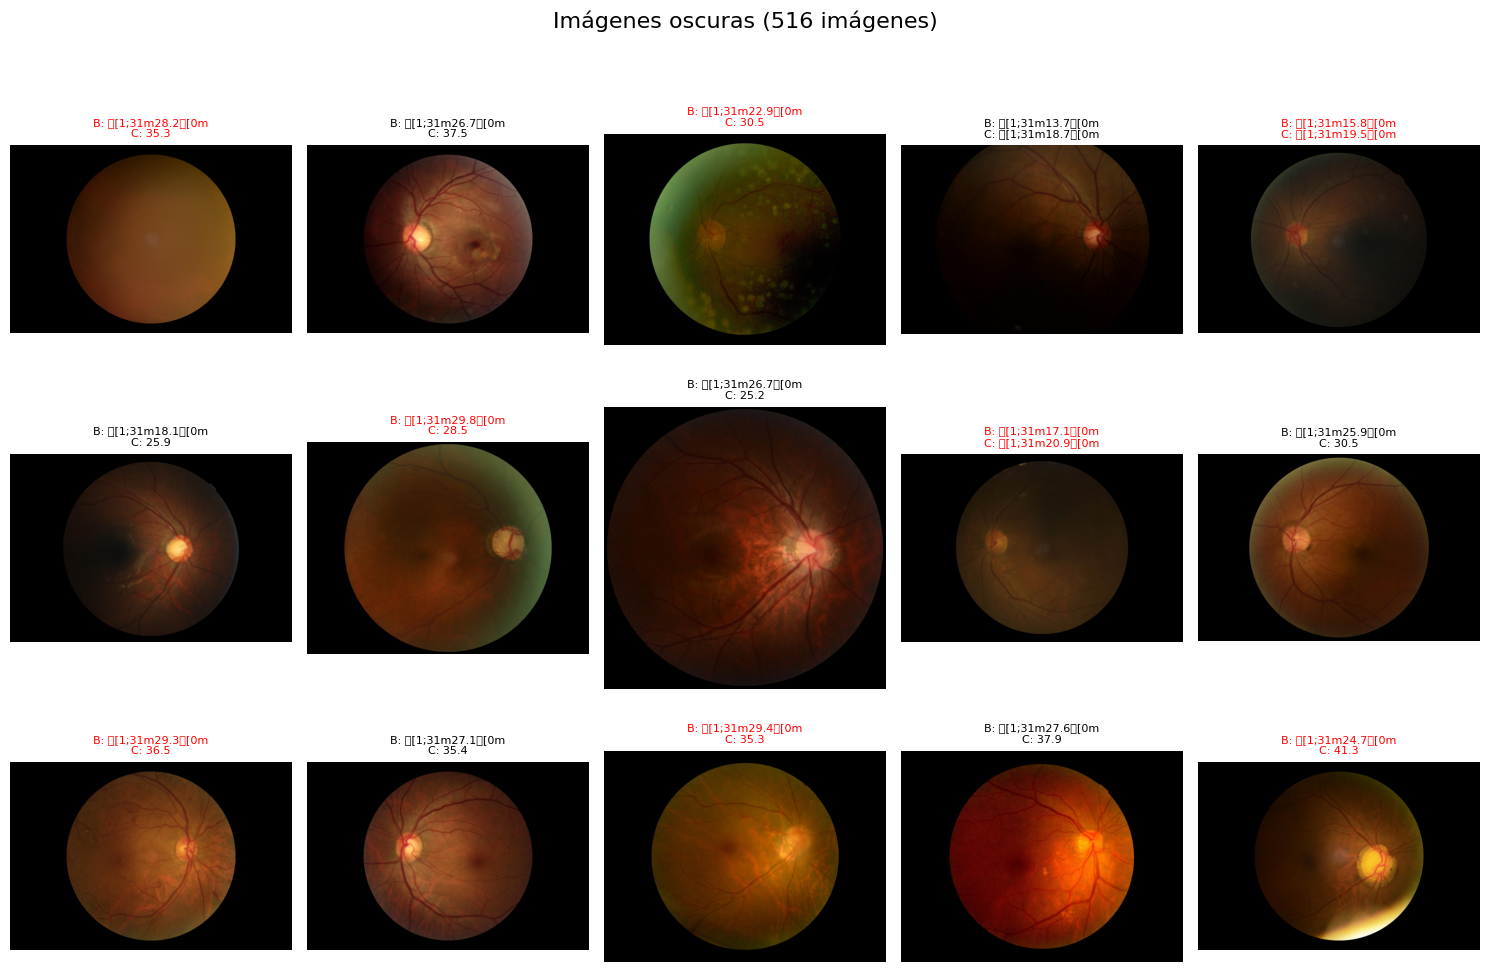

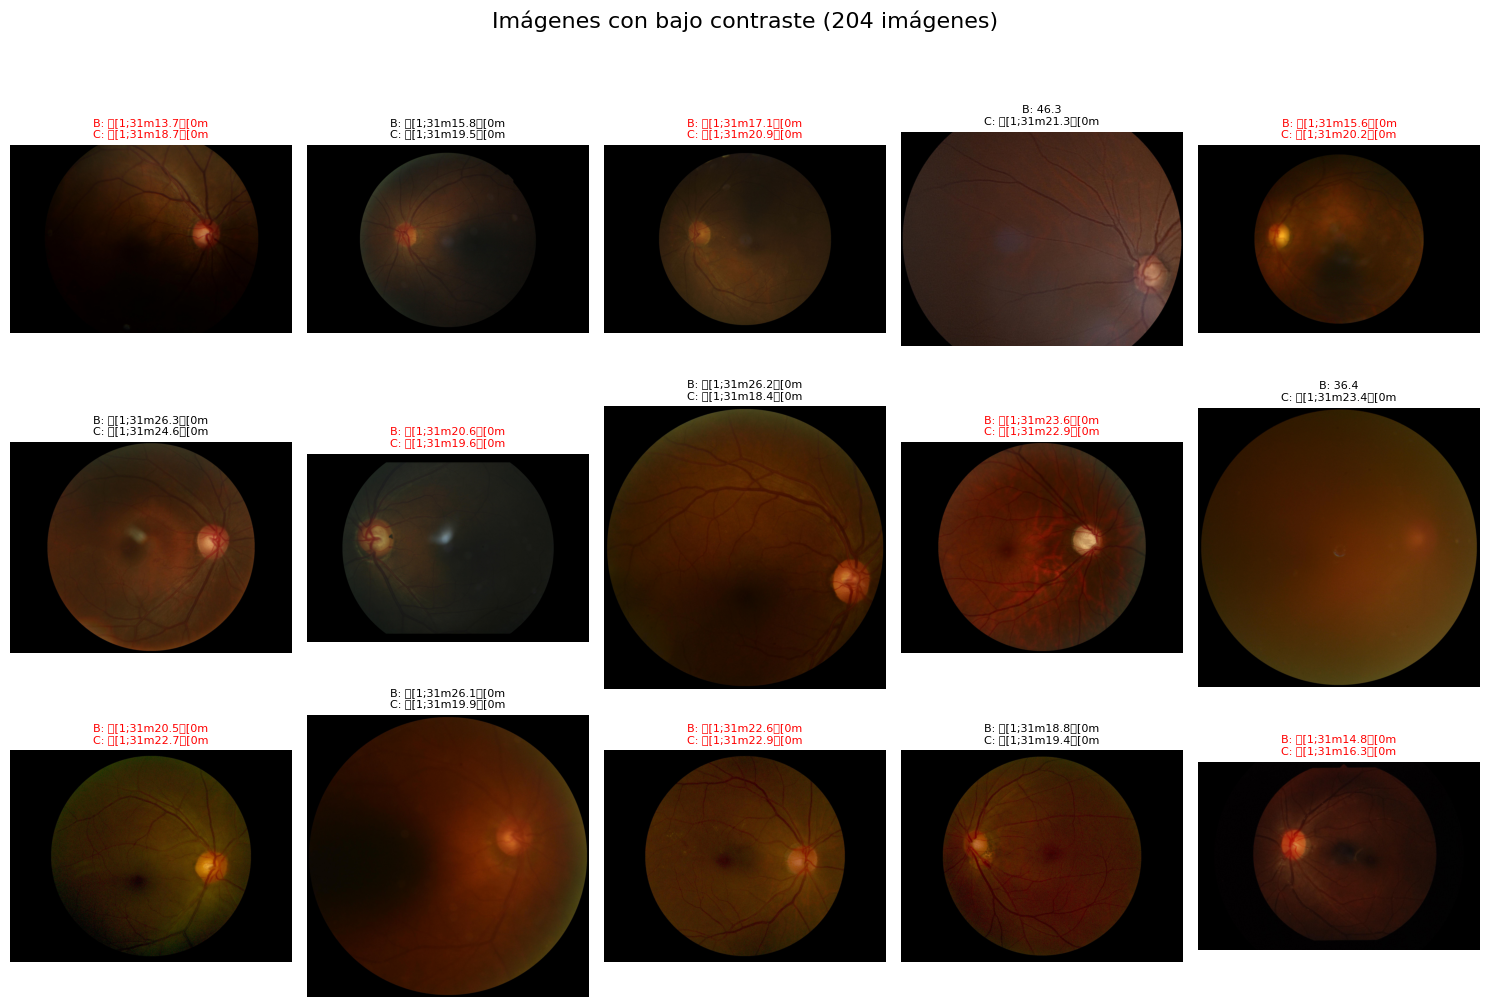

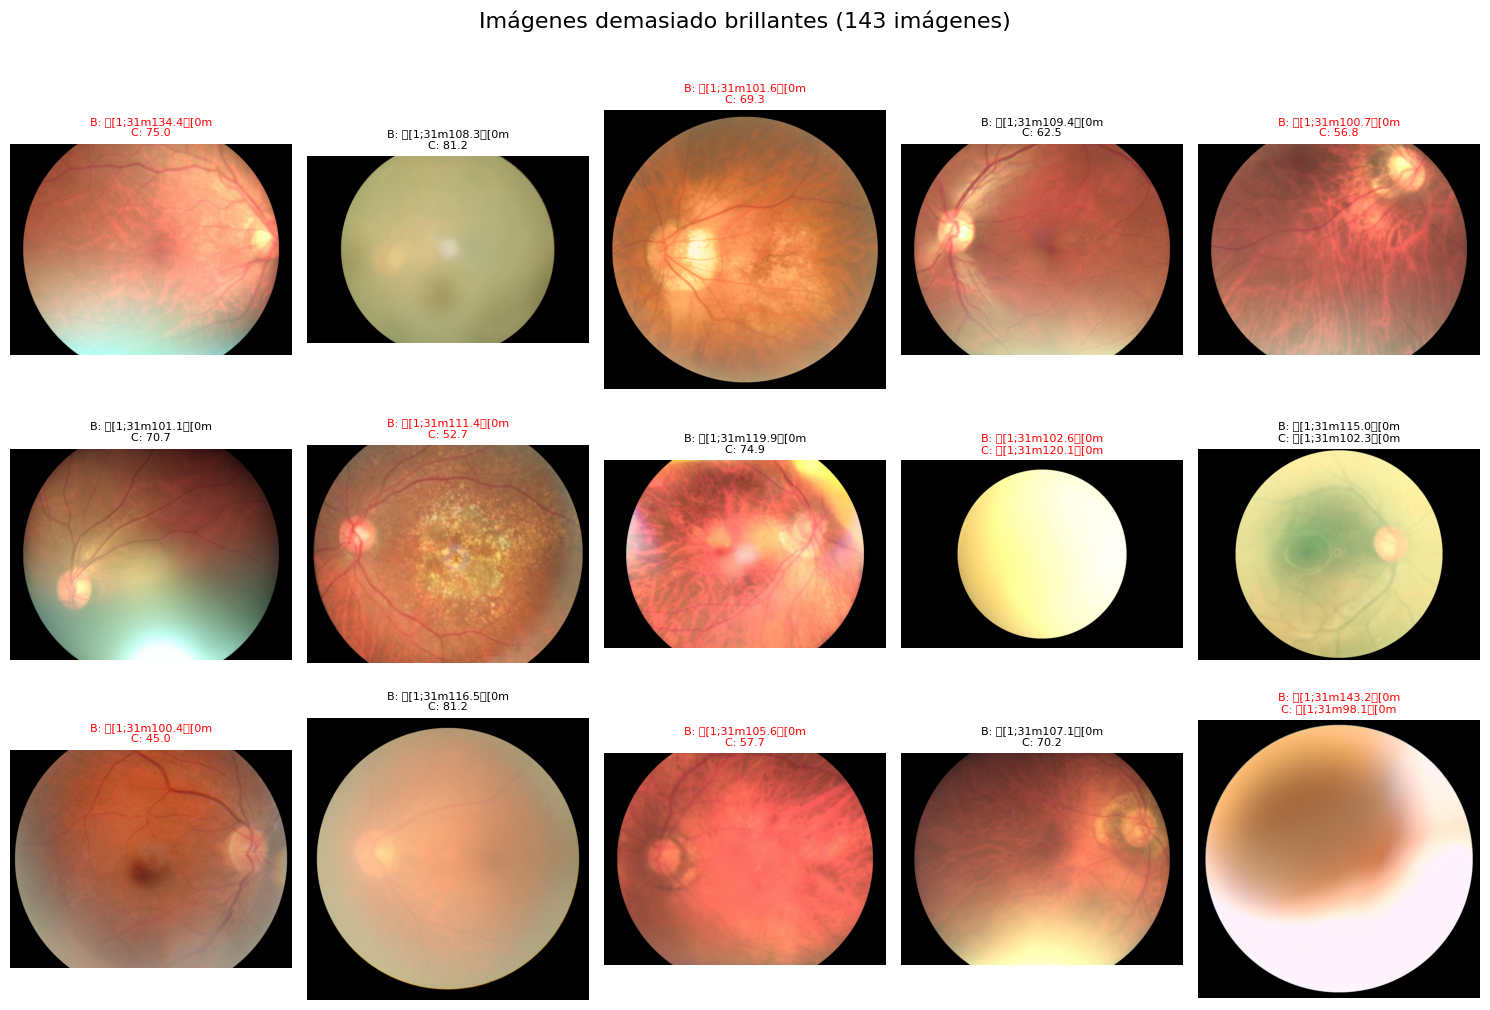

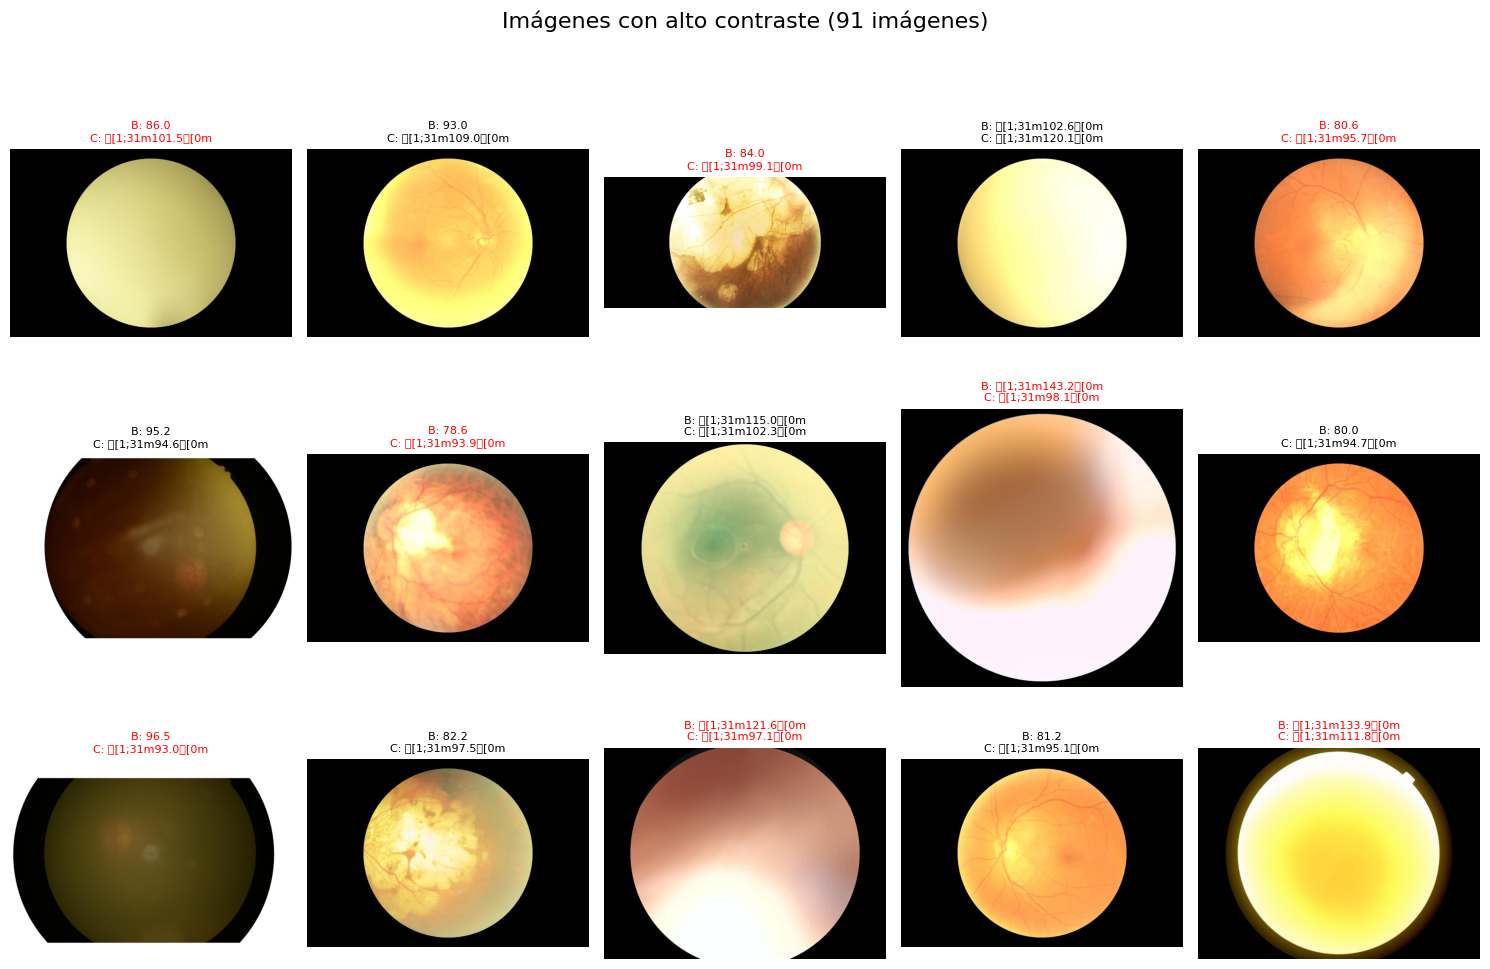

In [26]:
def display_examples(image_paths, title, max_examples=15):
    """
    Muestra un grid con ejemplos de imágenes problemáticas junto a sus métricas.
    """
    if not image_paths:
        print(f"No hay imágenes para mostrar en la categoría: {title}")
        return
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{title} ({len(image_paths)} imágenes)", y=1.02, fontsize=16)
    
    # Limitar el número de ejemplos y calcular el grid
    examples = image_paths[:max_examples]
    rows = int(np.ceil(len(examples)/5))
    
    for i, path in enumerate(examples, 1):
        plt.subplot(rows, 5, i)
        img = cv2.imread(path)
        if img is None:
            continue
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        
        # Calcular métricas
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        
        # Construir el título y color
        brightness_text = f"B: {brightness:.1f}"
        contrast_text = f"C: {contrast:.1f}"
        
        # Si la imagen es problemática, poner título en rojo
        if brightness < THRESHOLDS['dark'] or brightness > THRESHOLDS['bright']:
            brightness_text = f"B: \033[1;31m{brightness:.1f}\033[0m"
        if contrast < THRESHOLDS['low_contrast'] or contrast > THRESHOLDS['high_contrast']:
            contrast_text = f"C: \033[1;31m{contrast:.1f}\033[0m"
        
        plt.title(f"{brightness_text}\n{contrast_text}", fontsize=8, color='red' if i % 2 else 'black')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de todas las categorías
categories = {
    'dark': "Imágenes oscuras",
    'low_contrast': "Imágenes con bajo contraste",
    'bright': "Imágenes demasiado brillantes", 
    'high_contrast': "Imágenes con alto contraste"
}

for category, title in categories.items():
    if stats[f'{category}_images'] > 0:
        display_examples(stats[f'{category}_paths'], title)

### Distribución de imágenes por clase diagnóstica según calidad


In [27]:
# Crear DataFrame de calidad de imagen
# Etiquetas bianerias para las clases diagnósticas
label_cols = ["N", "D", "G", "C", "A", "H", "M", "O"]

rows = []

# Recorremos cada fila del dataframe
for i, r in df.iterrows():
    fname = r.get("filename")
    if pd.isna(fname):
        continue  

    path = os.path.join(image_dir, str(fname))
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        continue

    # Calculamos brillo y contraste en escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = float(np.mean(gray))  
    contrast = float(np.std(gray))    

    # Creamos los flags de calidad a partir de los umbrales
    is_dark = brightness < THRESHOLDS["dark"]
    is_bright = brightness > THRESHOLDS["bright"]
    is_low_contrast = contrast < THRESHOLDS["low_contrast"]
    is_high_contrast = contrast > THRESHOLDS["high_contrast"]

    # Parseamos la columna 'labels'
    raw = r.get("labels")
    if isinstance(raw, list):
        labs = [str(t).strip() for t in raw]
    elif isinstance(raw, str) and raw.strip():
        s = raw.strip().strip("[]").replace("'", "").replace('"', "")
        labs = [t.strip() for t in s.split(",") if t.strip()]
    else:
        labs = []

    # Creamos las columnas binarias a partir de la lista 'labs'
    flags = {c: int(c in labs) for c in label_cols}

    # Añadimos el registro de cada imagen
    rows.append({
        "ID": r.get("ID"),               
        "filename": fname,                
        "brightness": brightness,          
        "contrast": contrast,                
        "is_dark": is_dark,                
        "is_bright": is_bright,             
        "is_low_contrast": is_low_contrast,   
        "is_high_contrast": is_high_contrast, 
        **flags,                              
        "labels": ",".join(labs) if labs else "N/A",  
    })

# Convertimos la lista de registros en un DataFrame de calidad
quality_df = pd.DataFrame(rows)

print("DataFrame de calidad de imagen:", quality_df.shape)
quality_df.head()

DataFrame de calidad de imagen: (6392, 17)


ID     filename  brightness   contrast  is_dark  is_bright  \
0   0  0_right.jpg   33.274280  30.609474    False      False   
1   1  1_right.jpg   53.834958  65.333838    False      False   
2   2  2_right.jpg   34.812584  35.673807    False      False   
3   4  4_right.jpg   50.609196  64.242010    False      False   
4   5  5_right.jpg   71.283488  57.147460    False      False   

   is_low_contrast  is_high_contrast  N  D  G  C  A  H  M  O labels  
0            False             False  1  0  0  0  0  0  0  0      N  
1            False             False  1  0  0  0  0  0  0  0      N  
2            False             False  0  1  0  0  0  0  0  0      D  
3            False             False  0  1  0  0  0  0  0  0      D  
4            False             False  0  1  0  0  0  0  0  0      D

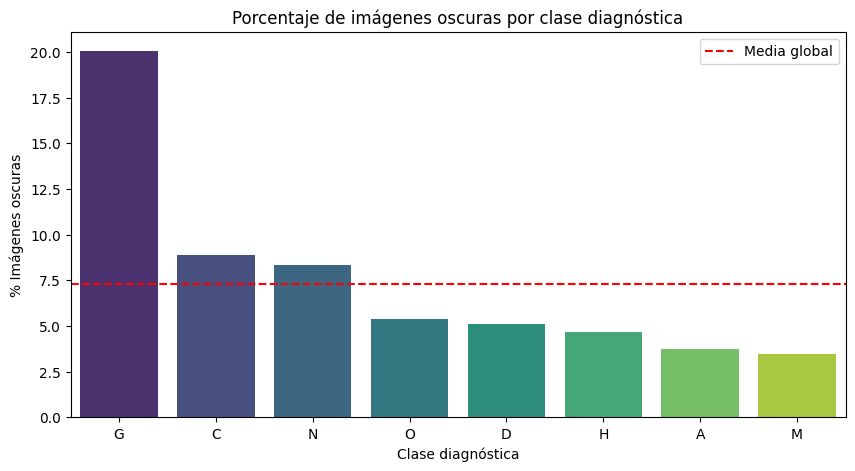

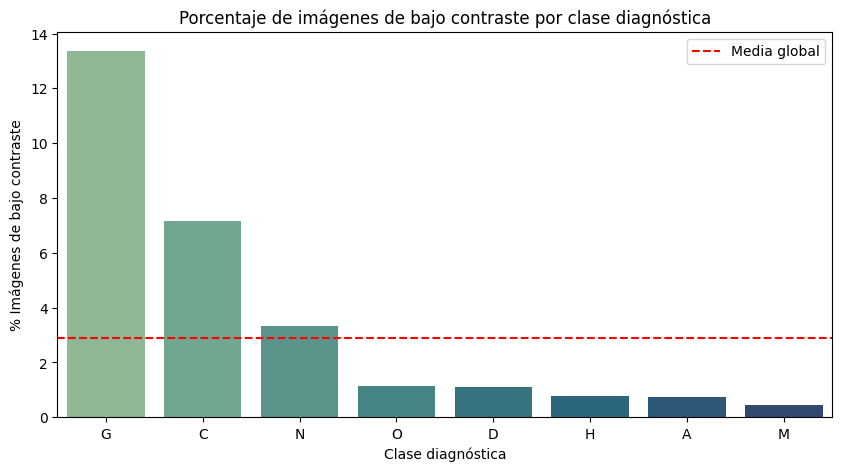

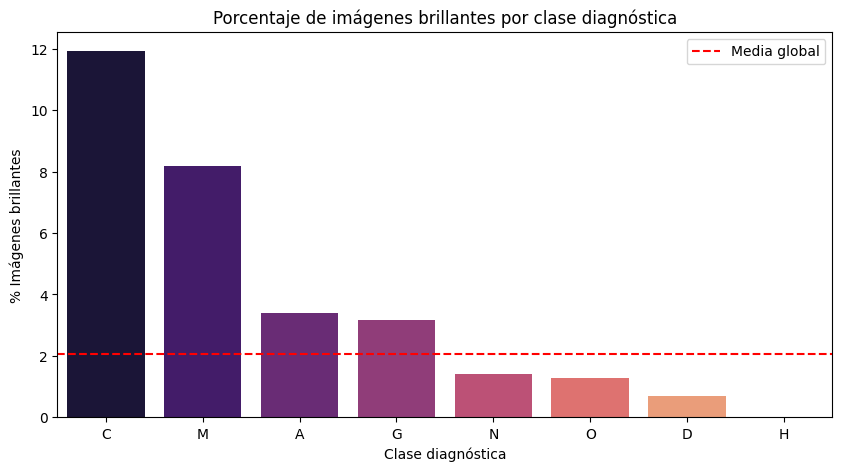

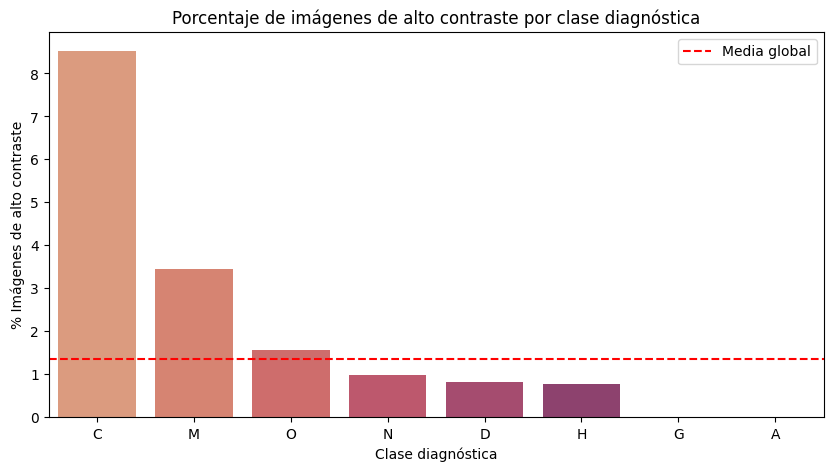

In [28]:
# Lista de Clases diagnósticas
diseases = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# 1)Imágenes oscuras
results_dark = []
for disease in diseases:
    total = quality_df[disease].sum()
    dark = quality_df[(quality_df[disease] == 1) & (quality_df['is_dark'])].shape[0]
    pct = (dark / total) * 100 if total > 0 else 0
    results_dark.append({'Disease': disease, 'Total': total, 'Count': dark, '%': pct})

pct_dark_df = pd.DataFrame(results_dark).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_dark_df, palette='viridis')
plt.title('Porcentaje de imágenes oscuras por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes oscuras')
plt.axhline(y=quality_df['is_dark'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()

# 2)Imágenes bajo contraste
results_low_contrast = []
for disease in diseases:
    total = quality_df[disease].sum()
    low_contrast = quality_df[(quality_df[disease] == 1) & (quality_df['is_low_contrast'])].shape[0]
    pct = (low_contrast / total) * 100 if total > 0 else 0
    results_low_contrast.append({'Disease': disease, 'Total': total, 'Count': low_contrast, '%': pct})

pct_low_contrast_df = pd.DataFrame(results_low_contrast).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_low_contrast_df, palette='crest')
plt.title('Porcentaje de imágenes de bajo contraste por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes de bajo contraste')
plt.axhline(y=quality_df['is_low_contrast'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()

# 3)Imágenes brillantes
results_bright = []
for disease in diseases:
    total = quality_df[disease].sum()
    bright = quality_df[(quality_df[disease] == 1) & (quality_df['is_bright'])].shape[0]
    pct = (bright / total) * 100 if total > 0 else 0
    results_bright.append({'Disease': disease, 'Total': total, 'Count': bright, '%': pct})

pct_bright_df = pd.DataFrame(results_bright).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_bright_df, palette='magma')
plt.title('Porcentaje de imágenes brillantes por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes brillantes')
plt.axhline(y=quality_df['is_bright'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()

# 4)Imágenes alto contraste
results_high_contrast = []
for disease in diseases:
    total = quality_df[disease].sum()
    high_contrast = quality_df[(quality_df[disease] == 1) & (quality_df['is_high_contrast'])].shape[0]
    pct = (high_contrast / total) * 100 if total > 0 else 0
    results_high_contrast.append({'Disease': disease, 'Total': total, 'Count': high_contrast, '%': pct})

pct_high_contrast_df = pd.DataFrame(results_high_contrast).sort_values('%', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Disease', y='%', data=pct_high_contrast_df, palette='flare')
plt.title('Porcentaje de imágenes de alto contraste por clase diagnóstica') 
plt.xlabel('Clase diagnóstica') 
plt.ylabel('% Imágenes de alto contraste')
plt.axhline(y=quality_df['is_high_contrast'].mean() * 100, color='red', linestyle='--', label='Media global')
plt.legend()
plt.show()


In [29]:
def plot_by_disease_and_category(disease, category, n_samples=5):
    """
    Muestra ejemplos de imágenes de una clase diagnóstica específica 
    que cumplen con una condición de calidad.
    
    Parámetros:                                                                                 
        disease (str): Código de la enfermedad (por ejemplo, 'G' para glaucoma).
        category (str): Categoría de calidad ('dark', 'bright', 'low_contrast', 'high_contrast').
        n_samples (int): Número de imágenes a visualizar (por defecto 5).
    """
    # Filtrar imágenes por clase y condición
    samples = quality_df[
        (quality_df[disease] == 1) & 
        (quality_df[f'is_{category}'])
    ].sample(min(n_samples, quality_df.shape[0]))

    # Visualización
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(image_dir, row['filename'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(f"B:{row['brightness']:.1f} | C:{row['contrast']:.1f}\n{row['labels']}", fontsize=8)
        plt.axis('off')

    plt.suptitle(f'Imágenes "{category}" - Clase {disease}', y=1.05)
    plt.show()

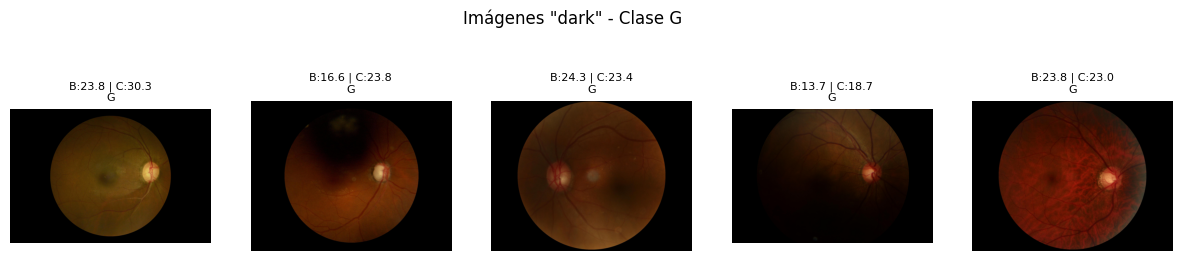

In [31]:
# Ejemplo para clase Glaucoma ('G')
plot_by_disease_and_category('G', 'dark')

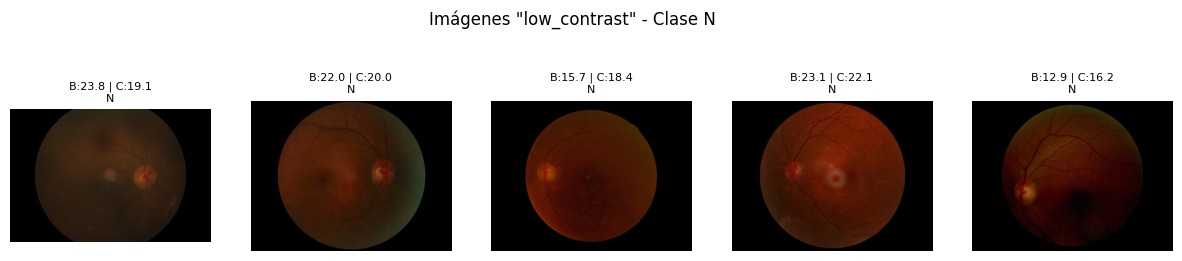

In [32]:
# Ejemplo para clase Normal ('N')
plot_by_disease_and_category('N', 'low_contrast')

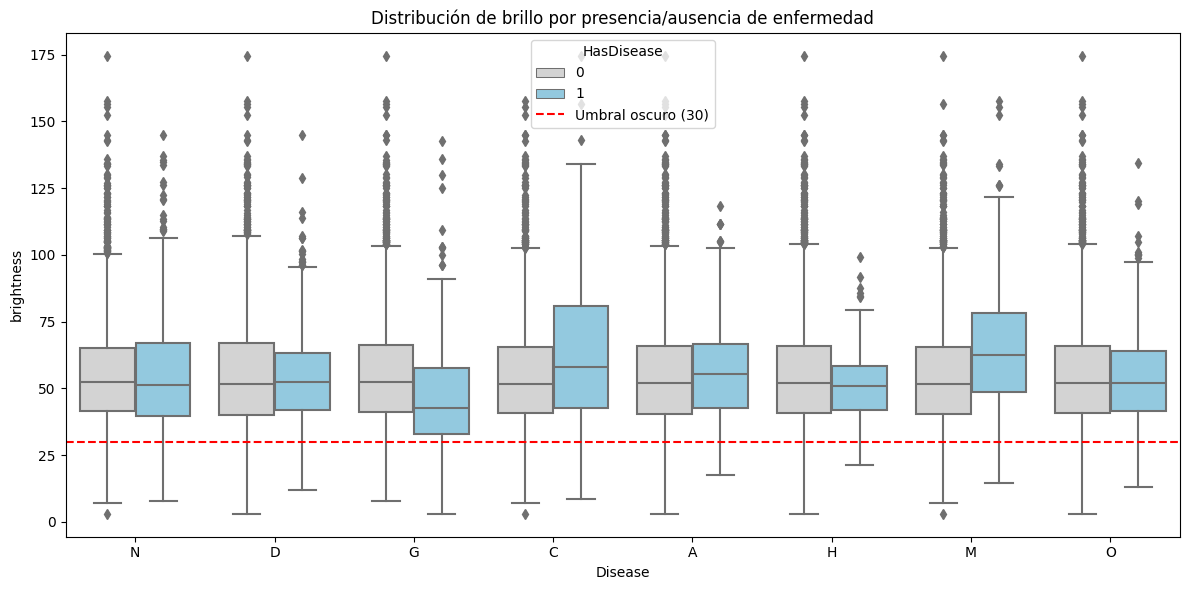

In [33]:
# Visualización de la distribución de brillo por presencia/ausencia de enfermedad
# Lista de clases diagnósticas
label_cols = ["N", "D", "G", "C", "A", "H", "M", "O"]

# Reorganizar el DataFrame para análisis por enfermedad
plot_df = quality_df.melt(
    id_vars=['brightness'],
    value_vars=label_cols,
    var_name='Disease',
    value_name='HasDisease'
)

# Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df,
    x='Disease',
    y='brightness',
    hue='HasDisease',
    palette={0: 'lightgray', 1: 'skyblue'}  # 0 = sin enfermedad, 1 = con enfermedad
)

# Línea de referencia para el umbral de imágenes oscuras
plt.axhline(
    y=THRESHOLDS['dark'], 
    color='red', 
    linestyle='--', 
    label=f"Umbral oscuro ({THRESHOLDS['dark']})"
)

plt.title('Distribución de brillo por presencia/ausencia de enfermedad')
plt.legend(title='HasDisease')
plt.tight_layout()
plt.show()


Aplicamos un test estadístico (t-test independiente) para comparar si hay diferencias significativas en el brillo medio entre imágenes con y sin cada una de las enfermedadades.

In [34]:
# Comparación de brillo entre grupos con y sin enfermedad
# Lista de columnas de etiquetas binarias
label_cols = ["N", "D", "G", "C", "A", "H", "M", "O"]

def compare_brightness_simple(quality_df, diseases):
    """
    Compara el brillo medio entre imágenes con y sin cada enfermedad usando prueba t de Welch.
    
    Parámetros:
    - quality_df: DataFrame con columnas 'brightness' y las enfermedades como columnas binarias (0/1)
    - diseases: lista con los nombres de las columnas de enfermedades
    """
    rows = []
    for d in diseases:
        # Brillo para imágenes con la enfermedad
        g1 = quality_df.loc[quality_df[d] == 1, 'brightness'].dropna()
        # Brillo para imágenes sin la enfermedad
        g0 = quality_df.loc[quality_df[d] == 0, 'brightness'].dropna()
        
        # Prueba t de Welch
        t_stat, p_val = ttest_ind(g1, g0, equal_var=False)
        
        # Añadir resultados
        rows.append({
            'Disease': d,
            'n_with': len(g1),
            'n_without': len(g0),
            'mean_brightness_with': g1.mean(),
            'mean_brightness_without': g0.mean(),
            'mean_diff': g1.mean() - g0.mean(),
            'p_value': p_val
        })
    
    # Ordenar por p-valor
    out = pd.DataFrame(rows).sort_values('p_value').reset_index(drop=True)
    return out

# Ejecutar y mostrar resumen
brightness_summary = compare_brightness_simple(quality_df, label_cols)
brightness_summary

Disease  n_with  n_without  mean_brightness_with  mean_brightness_without  \
0       M     232       6160             65.889023                54.066037   
1       G     284       6108             46.797581                54.853066   
2       C     293       6099             62.780021                54.097146   
3       N    2873       3519             53.850602                55.021386   
4       H     128       6264             51.585135                54.554620   
5       A     266       6126             56.599459                54.403784   
6       D    1608       4784             53.821767                54.721496   
7       O     708       5684             54.301118                54.519326   

   mean_diff       p_value  
0  11.822986  4.130288e-12  
1  -8.055484  3.614651e-09  
2   8.682876  4.744749e-07  
3  -1.170784  1.641094e-02  
4  -2.969485  2.084773e-02  
5   2.195675  6.107776e-02  
6  -0.899729  7.180914e-02  
7  -0.218208  7.572183e-01